In [1]:
import torch
import shap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Shap interpretation

In [2]:
class ResNet50Transfer(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Transfer, self).__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze all layers (optional: you can unfreeze later for fine-tuning)
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        for name, param in self.base_model.named_parameters():
            if "layer4" in name or "layer3" in name:  # Unfreeze only final block
                param.requires_grad = True

        in_features = self.base_model.fc.in_features  # Usually 2048
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes) 
        )

    def forward(self, x):
        return self.base_model(x)


In [3]:
# https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/2

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])  
        label = torch.tensor(self.labels[idx], dtype=torch.long) 

        if self.transform:
            image = self.transform(image)
            
        
        return image, label

Scieżka do modelu

In [4]:
model = ResNet50Transfer(num_classes=3) 
model.load_state_dict(torch.load("model_cropped_photos_radius_50.pth", map_location=torch.device('cpu')))

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
device=torch.device("cpu")

Funkcja obrazująca które fragmenty miały znaczenie przy klasufikacji (różowe - klasyfikacja do danej klasy, niebieskie-przeciwko tej klasie).

In [16]:
def get_shap_interpretation(model, path, start, stop, batch_number):
    
    class_names = ['AVM', 'Normal', 'Ulcer'] 
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset=ImageFolder(path, transform=transform)
    batch_size = 32
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval() 
    
    images, labels = list(loader)[batch_number]

    start_index = batch_number * batch_size 
    filenames = [sample[0] for sample in dataset.samples]
    batch_filenames = filenames[start_index:start_index + batch_size]

    for k in range(start, stop):
        filename = batch_filenames[k - start]  
        print("Nazwa pliku:", filename)


    images = images.cpu() 
    labels = labels.cpu() 

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    def f(x):
        tmp = torch.tensor(x).permute(0, 3, 1, 2).float().to(device) 
        with torch.no_grad():
            return model(tmp)  

    images = images.permute(0, 3, 2, 1).numpy() 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #denormalizacja
    images_denorm = images * std + mean  
    images_denorm = np.clip(images_denorm, 0, 1)  
    images_denorm = np.uint8(images_denorm * 255) 

    masker = shap.maskers.Image("inpaint_telea", images_denorm.shape[1:]) 

    explainer = shap.Explainer(f, masker, output_names=class_names)

    shap_values = explainer(images_denorm[start:stop], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

    shap.image_plot(shap_values)


Nazwa pliku: cropped_out_50\AVM\AVM_2024-08-07-08-01-08_15875.bmp
Nazwa pliku: cropped_out_50\AVM\AVM_2024-08-07-08-01-08_42215.bmp
Nazwa pliku: cropped_out_50\AVM\AVM_2024-08-07-08-01-08_46388.bmp


PartitionExplainer explainer: 4it [03:46, 75.38s/it]                       


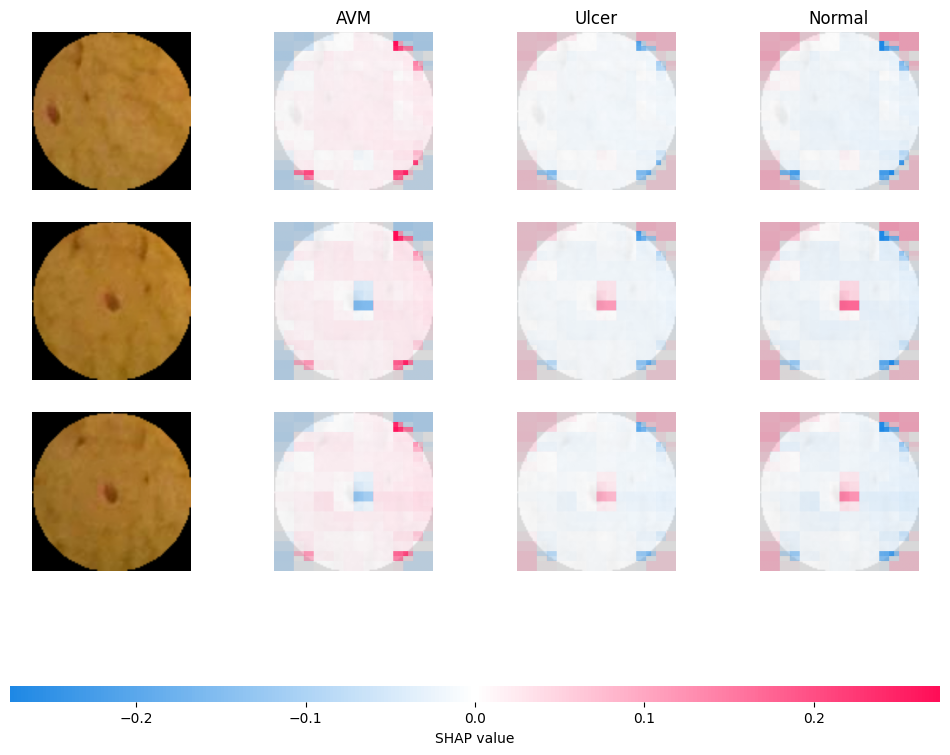

In [17]:
get_shap_interpretation(model, "cropped_out_50", 2, 5, 0)

Wyniki pokazały, że czasami miejsce zmiany chorobowej było interpretowane przeciwko klasyfikacji do właściwej klasy klasy, a krawędzie obrazu (nieistotne dla choroby miejsca) wpływały na zaklasyfikowanie do odpowiedniej klasy. Czyli nawet zawężenie obszaru obrazka przekazanego do nauki, oraz zapewnienie, że podobne zdjęcia będą znajdować się raczej w jednym zbiorze (treningowym lub testowym, osiągnięte za pomocą klasteryzacji, która nie jest 100 procentowo skuteczna) nie poprawiło interpretowalności. Z bardzo małej liczby zdjęć (po klasteryzacji i usunięciu potencjalnych duplikatów pozostało mniej niż 1000 zdjęć) ciężko jest wytrenować dobry model, który ma uogólniać.